In [1]:
######################################## Paquetes #####################################
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from astropy.convolution import Gaussian1DKernel,convolve
import scipy.integrate as integrate
from scipy.stats import linregress as lin 
from astropy import units as u
import os
import math
from scipy.stats import vonmises
from astropy.table import Table
from astropy.stats import sigma_clip
from astropy.timeseries import TimeSeries
from astropy.time import Time
from scipy.special import i0
from sklearn import linear_model
from sklearn.linear_model import HuberRegressor as HR
from sklearn.metrics import mean_squared_error
from scipy import stats

In [2]:
######################################## Fourier #####################################

def fourier_g(T0,period,times,mags,n):
    T0=0.
    temp = []
    cn = []
    ph1 = ((times - T0) /period)-np.floor((times - T0)/period)    
    temp.append(np.ones(len(ph1)).reshape(-1,1))
    cn.append('c')
    
    for i in range(n):
        temp.append((np.sin(2*(i+1)*np.pi*ph1)).reshape(-1,1))
        cn.append('a'+str(i+1))
    for j in range(n):
        temp.append((np.cos(2*(j+1)*np.pi*ph1)).reshape(-1,1))
        cn.append('b'+str(j+1))

    df = pd.DataFrame(np.concatenate(temp,axis=1),columns=cn)
    X_tr = df[cn]
    Y_tr = mags
    model = HR(fit_intercept = False,max_iter=1000000) #model
    model.fit(X_tr,Y_tr)    
    coeff=model.fit(X_tr,Y_tr)
    coeff = coeff.coef_ 
    return(model,coeff)

def evaluar_g(T0,modelo,times,period,mags,n):
    T0=0.
    ph1 = ((times - T0) /period)-np.floor((times - T0)/period)
    cn1 = []
    temp1 = []
    A0= mags.mean() 
    
    temp1.append(np.ones(len(ph1)).reshape(-1,1))
    cn1.append('c')
    
    for u in range(n):
        temp1.append((np.sin(2*(u+1)*np.pi*ph1)).reshape(-1,1))
        cn1.append('a'+str(u+1))
    for v in range(n):
        temp1.append((np.cos(2*(v+1)*np.pi*ph1)).reshape(-1,1))
        cn1.append('b'+str(v+1))
    df1 = pd.DataFrame(np.concatenate(temp1,axis=1),columns=cn1)
    return(modelo.predict(df1[cn1]))

def fourier_band(T0,period,times,mags,n,coeff,n_band):
    T0=0.
    temp = []
    cn = []
    A0= mags.mean()
    ph1 = ((times - T0) /period)-np.floor((times - T0)/period)
    
    temp.append(coeff[0]*np.ones(len(ph1)).reshape(-1,1))
    cn.append('c')
    
    for i in range(n):
        if i < n_band:
            temp.append((np.sin(2*(i+1)*np.pi*ph1)*coeff[i+1]).reshape(-1,1))
            cn.append('a'+str(i+1))
        else:
            temp.append((np.sin(2*(i+1)*np.pi*ph1)*coeff[i+1]*0).reshape(-1,1))
            cn.append('a'+str(i+1))
    for j in range(n):
        if j < n_band:
            temp.append((np.cos(2*(j+1)*np.pi*ph1)*coeff[j+n+1]).reshape(-1,1))
            cn.append('b'+str(j+1))
        else:
            temp.append((np.cos(2*(j+1)*np.pi*ph1)*coeff[j+n+1]*0).reshape(-1,1))
            cn.append('b'+str(j+1))
            
    df = pd.DataFrame(np.concatenate(temp,axis=1),columns=cn)
    X_tr = df[cn]
    Y_tr = mags
    model = HR(fit_intercept = False,max_iter=1000000)
    model.fit(X_tr,Y_tr)   
    coeff=model.fit(X_tr,Y_tr)
    coeff = coeff.coef_ 
    return(model,coeff)

def evaluar_band(T0,modelo,times,period,mags,n,coeff,n_band):
    T0=0.
    ph1 = ((times - T0) /period)-np.floor((times - T0)/period)
    cn1 = []
    temp1 = []
    A0= mags.mean()
    
    temp1.append(coeff[0]*np.ones(len(ph1)).reshape(-1,1))
    cn1.append('c')
    
    for u in range(n):
        if u < n_band:
            temp1.append((np.sin(2*(u+1)*np.pi*ph1)*coeff[u+1]).reshape(-1,1))
            cn1.append('a'+str(u+1))
        else:
            temp1.append((np.sin(2*(u+1)*np.pi*ph1)*coeff[u+1]*0.).reshape(-1,1))
            cn1.append('a'+str(u+1))
            
    for v in range(n):
        if v < n_band:
            temp1.append((np.cos(2*(v+1)*np.pi*ph1)*coeff[v+n+1]).reshape(-1,1))
            cn1.append('b'+str(v+1))
        else:
            temp1.append((np.cos(2*(v+1)*np.pi*ph1)*coeff[v+n+1]*0.).reshape(-1,1))
            cn1.append('b'+str(v+1))
            
    df1 = pd.DataFrame(np.concatenate(temp1,axis=1),columns=cn1)
    return(modelo.predict(df1[cn1]))

# Esto es para gráficar correctamente las curvas de luz

def fourier_corrected(m_X, phase_max_fourier, evaluate):
    new_phase_positive, new_phase_negative = [], []
    evaluate_positive, evaluate_negative = [], []
    for i in range(len(m_X)):
        new_phase = m_X[i] - phase_max_fourier
        if new_phase <= 0:
            new_phase_negative.append(1 + new_phase)
            evaluate_negative.append(evaluate[i])
        else:
            new_phase_positive.append(new_phase)
            evaluate_positive.append(evaluate[i])
            
    phase_corrected = new_phase_positive + new_phase_negative
    evaluate_corrected = evaluate_positive + evaluate_negative
    
    return (phase_corrected, evaluate_corrected)

In [3]:
######################################## Sigma clipping #####################################

def dist_euclidiana_min(mo,po,m_X,evaluate):
    dist_list, index_list = [], []
    for i in range(len(mo)):      
        dist = np.sqrt((mo[i]-evaluate)**2 + (po[i]-m_X)**2)
        index = np.where(dist==np.min(dist))[0][0]
        min_dist = dist[index].value
        
        index_phase_fourier = (np.abs(np.array(m_X) - po[i])).argmin()
        mag_f = evaluate[index_phase_fourier]
        mag_o = mo[i]
        if mag_o > mag_f:
            min_dist = -1*min_dist
            dist_list.append(min_dist)
            index_list.append(index)
        else:
            dist_list.append(min_dist)
            index_list.append(index)
    
    return(dist_list, index_list) # index_lista: phase donde esta la dist minima

def ell(evaluate,m_X,index_list):
    ell_list= []
    #primer paso: derivar
    dev= np.gradient(evaluate,m_X) # el 0.001 es el espaciado de m_X
    #segundo paso: integrar
    term= np.sqrt((dev**2) + 1)
    l_total= np.trapz(term,m_X)  
    for i in index_list:
       #print(i)
        if i != 0:
            dev_range= np.gradient(evaluate[:i+1],m_X[:i+1])
            term_range= np.sqrt((dev_range**2) + 1)
            l= np.trapz(term_range,m_X[:i+1])
            ell_list.append(l/l_total) #normalizamos
        else:
            ell_list.append(0)
            
    return(ell_list)

def sigmas(evaluate,m_x,index_list,err):
    m_list=[] #lista de pendientes
    #la pendiente sera la derivada
    m= np.gradient(evaluate,m_X)
    for i in index_list:
        m_dist= m[i]
        m_list.append(m_dist)
    theta= np.arctan(np.array(m_list))- (np.pi/2)
    sigma_obs = []
    for i in range(len(err)):
        sigma_obs.append(err[i])
    sigma_l= np.array(sigma_obs)*np.cos(theta)
    sigma_d= np.array(sigma_obs)*np.sin(theta)
    return(np.abs(sigma_l),np.abs(sigma_d))  

def remove2(dist,err_d,obs,phase,err,t,s,i):
    obs_clipped=[]
    obs_out= []
    error_out= []
    phase_clipped=[]
    phase_out= []
    error_clipped=[]
    t_out= []
    t_clipped=[]
    
    media= np.mean(dist)
    std= np.std(dist)
    
    new_df = sigma_clip(dist, sigma=s ,maxiters=i, cenfunc='median')
    media= np.mean(dist)
    
    for i in range(len(new_df)):
        if new_df[i] != '--':
            obs_c = obs[i].value
            phase_c= phase[i]
            error_c= err[i].value
            t_c= t[i].value
            
            obs_clipped.append(obs_c)
            phase_clipped.append(phase_c)
            error_clipped.append(error_c)
            t_clipped.append(t_c)

        else:
            obs_o = obs[i].value
            phase_o= phase[i]
            error_o= err[i].value
            t_o= t[i].value
            
            obs_out.append(obs_o)
            phase_out.append(phase_o)
            error_out.append(error_o)
            t_out.append(t_o)
            
    return(obs_clipped,phase_clipped,error_clipped,obs_out,phase_out,error_out,t_clipped,t_out,media,std)

def remove3(dist,ell,err,s,i):
    #aca no es la phase, es el ell
    dist_out= []
    l_out= []
    err_out= []
    
    dist_c= []
    l_c= []
    
    
    new_df = sigma_clip(dist, sigma=s ,maxiters=i, cenfunc='median')
    
    for i in range(len(new_df)):
        if new_df[i] != '--':
            obs_c = dist[i]
            ll_c= ell[i]
            dist_c.append(obs_c)
            l_c.append(ll_c)
            
        else:
            obs_o = dist[i]
            ll_o= ell[i]
            e= err[i]
            
            dist_out.append(obs_o)
            l_out.append(ll_o)
            err_out.append(e)
    
    median_c= np.median(dist_c)
    std_c= np.std(dist_c)
    return(dist_out,l_out,err_out,median_c,std_c)


Archivo: OGLE-BLG-RRLYR-11208.csv ,  Estrella n= 1


/Users/carinae/anaconda3/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 410 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/carinae/anaconda3/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/carinae/anaconda3/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/carinae/anaconda3/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 706 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/carinae/anaconda3/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "du

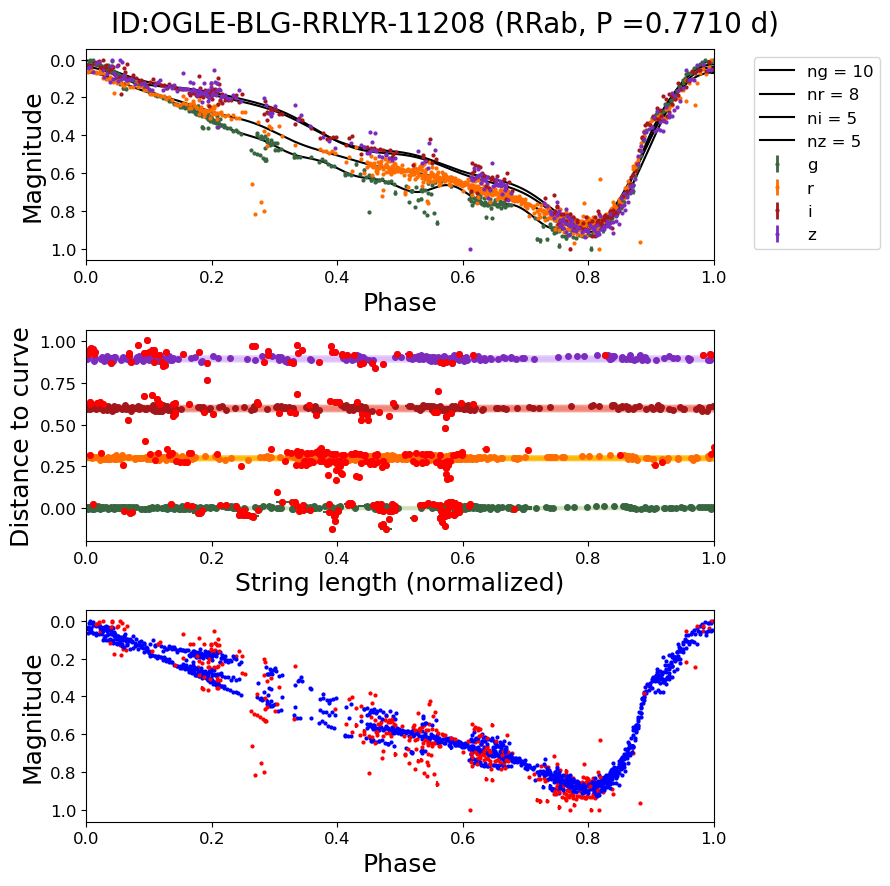

In [5]:
###################################### Información de las estrellas ######################################
stars_periods = pd.read_csv('./RR/Period_RR_Decaps.csv')
T= pd.read_csv('./RR/T_RR.csv')
N= pd.read_csv("./RR/new_N_templates.csv")
Type= pd.read_csv("./RR/type_rr.csv")
LighCurve= [f for f in os.listdir('./RR/data_sigmaclipping/RRab_3s5i/try') if f.endswith('.csv')]
new_data = pd.DataFrame(columns=('source_id', 'z_g','z_r','z_i','z_z'))

###############################################################################################

c=1

for arch in LighCurve:
    print("Archivo:",arch,", " ,"Estrella n=",c)
    df_d= pd.DataFrame()
    df_d1= pd.DataFrame()
    df_d2= pd.DataFrame()

    df = pd.read_csv('./RR/data_sigmaclipping/RRab_3s5i/try/' + str(arch))
    bands = ['g', 'r', 'i', 'z']
    color= [ '#386641' , '#ff6d00' ,'#a4161a', '#7b2cbf']
    
    m_X = np.arange(0,1.01,0.001)
    fig2, ax2 = plt.subplots(3,figsize = (9,9))


    df_bands = []
    coeff_gband= []
    coeff_band= []
    phase_band = []
    model_band = []
    evaluate_band= []
    time_band= []
    mag_band= []
    fphase_band= []
    phase_band = []
    err_band= []
    amplitud_band= []
    
    #########guardar en archivo##########
    magnitud_new=[]
    phase_new=[]
    err_new=[]
    time_new=[]
    band_new=[]
    
    magnitud_new1=[]
    phase_new1=[]
    err_new1=[]
    time_new1=[]
    band_new1=[]
    ####################################
    for band in bands:
        fm_X = np.arange(0,1.01,0.001)
        df_band  = df.loc[ df['band'] == band ].reset_index(drop=True)
        df_bands.append(df_band) 
        t1= np.array(df_band.HJD)
        time_band.append(t1)
        mag= np.array(df_band.Mag)
        mag_band.append(mag)
        err= np.array(df_band.Err)
        err_band.append(err)
        typ= Type.loc[Type['source_id'] == str(arch[:-4])].reset_index(drop=True).loc[0,'Type']
        n_g= int(N.loc[N['source_id'] == str(arch[:-4])].reset_index(drop=True).loc[0,'N_g'])
        n_r= int(N.loc[N['source_id'] == str(arch[:-4])].reset_index(drop=True).loc[0,'N_r'])
        n_i= int(N.loc[N['source_id'] == str(arch[:-4])].reset_index(drop=True).loc[0,'N_i'])
        n_z= int(N.loc[N['source_id'] == str(arch[:-4])].reset_index(drop=True).loc[0,'N_z'])
        period= stars_periods.loc[stars_periods['source_id'] == str(arch[:-4])].reset_index(drop=True).loc[ 0,'period' ]
        T0= T.loc[T['source_id'] == str(arch[:-4])].reset_index(drop=True).loc[0,'T']

        #---------------------------- Phase-------------------
        phase1 = ((t1 - T0)/(period)) - (np.floor((t1 - T0)/(period)))
        phase_band.append(phase1)

        if band == 'g':
            model = fourier_g(T0,period,t1,mag,n_g)[0]
            coeff_g = fourier_g(T0,period,t1,mag,n_g)[1]
            evaluate = evaluar_g(T0,model,m_X*period,period,mag,n_g).flatten()
            coeff_gband.append(coeff_g)
        elif band == 'r':
            model = fourier_band(T0,period,t1,mag,n_g,coeff_g,n_r)[0]
            coeff = fourier_band(T0,period,t1,mag,n_g,coeff_g,n_r)[1]
            evaluate = evaluar_band(T0,model,m_X*period,period,mag,n_g,coeff_g,n_r).flatten()
            coeff_band.append(coeff)
        elif band == 'i':
            model = fourier_band(T0,period,t1,mag,n_g,coeff_g,n_i)[0]
            coeff = fourier_band(T0,period,t1,mag,n_g,coeff_g,n_i)[1]
            evaluate = evaluar_band(T0,model,m_X*period,period,mag,n_g,coeff_g,n_i).flatten()
            coeff_band.append(coeff)
        elif band == 'z':
            model = fourier_band(T0,period,t1,mag,n_g,coeff_g,n_z)[0]
            coeff = fourier_band(T0,period,t1,mag,n_g,coeff_g,n_z)[1]
            evaluate = evaluar_band(T0,model,m_X*period,period,mag,n_g,coeff_g,n_z).flatten()
            coeff_band.append(coeff)

        model_band.append(model)
        evaluate_band.append(evaluate) #mag
        fphase_band.append(fm_X)


    mag_fourier_series = pd.Series(evaluate_band)
    m_X_series= pd.Series(m_X)

    mags_fourier = np.array([])
    band_fourier= np.array([])
    phase_fourier= np.array([])

    for i in range(len(bands)): 
        band = bands[i]
        t_clipped= Time(time_band[i], format= 'jd')
        data_clipped= np.array(mag_band[i])*u.dimensionless_unscaled
        error_clipped= np.array(err_band[i])*u.dimensionless_unscaled
        time_series= []

        maxima= np.min(mag_band[i])
        index_max= mag_band[i].tolist().index(maxima) 

        for j in range(len(t_clipped)):
            time_series.append([t_clipped[j],data_clipped[j], error_clipped[j]])

        tabla= Table(data=np.array(time_series),names= ["time", "data","error"]) 
        ts= TimeSeries(tabla)
        ts_folded_clipped= ts.fold(period=period*u.day, epoch_time= ts.time[index_max], wrap_phase= 1, normalize_phase= True) #que me situe el max en el 1
        
        if band == 'g':
            model = fourier_g(time_band[i][index_max],period,np.array(time_band[i]),np.array(mag_band[i]),n_g)[0]
            coeff = fourier_g(time_band[i][index_max],period,np.array(time_band[i]),np.array(mag_band[i]),n_g)[1]
            evaluate = evaluar_g(time_band[i][index_max],model,(m_X+(time_band[i][index_max]/period))*period,period,np.array(mag_band[i]),n_g)
            index_max_fourier = evaluate.tolist().index(np.min(evaluate)) #indice del maximo de fourier
            phase_max_fourier = m_X[index_max_fourier] #phase del maximo de fourier
            #################
            ts_folded_new= ts.fold(period=period*u.day, epoch_time = ts.time[index_max], epoch_phase= 1 - phase_max_fourier, wrap_phase= 1, normalize_phase= True)
            
            max_dot= ts_folded_new['data'].min() # punto maximo de la curva
            min_dot= ts_folded_new['data'].max()
            new_evaluate = (evaluate-max_dot)/(min_dot - max_dot)
            new_mag= (ts_folded_clipped['data']-max_dot)/(min_dot - max_dot)

            phase_corrected, evaluate_corrected = fourier_corrected(m_X, phase_max_fourier, new_evaluate)
            ax2[0].plot(phase_corrected, evaluate_corrected, c = 'k', label = f'ng = {n_g}')           
            ax2[0].errorbar(ts_folded_new.time,new_mag,ts_folded_new['error'],ms= 2, fmt= 'o',elinewidth= 2 , label=  bands[i], c= color[i])
            ###############
            dist_g= dist_euclidiana_min(new_mag,ts_folded_new.time,phase_corrected,evaluate_corrected) 
            l_g= ell(evaluate_corrected,phase_corrected,dist_g[1])
            error_l= sigmas(evaluate_corrected,phase_corrected,dist_g[1],ts_folded_new['error'])[0]
            error_d= sigmas(evaluate_corrected,phase_corrected,dist_g[1],ts_folded_new['error'])[1]
            d_out= remove3(dist_g[0],l_g,ts_folded_new['error'],2,5)

            ax2[1].errorbar(np.array(l_g),np.array(dist_g[0]),yerr=error_d, xerr=error_l, fmt = 'o' ,ms=4, c='#386641')
            ax2[1].errorbar(np.array(d_out[1]),np.array(d_out[0]),np.array(d_out[2]), fmt = 'o' ,ms=4, c='red', zorder=2)

            ax2[1].fill_between(phase_corrected,d_out[3]-1*d_out[4], d_out[3]+1*d_out[4],alpha=0.9, color='#cfe1b9') 
            ax2[1].fill_between(phase_corrected,d_out[3]-2*d_out[4], d_out[3]+2*d_out[4],alpha=0.6, color='#cfe1b9') 

            ################## 
        
            dots_remove2= remove2(dist_g[0],error_d,ts_folded_new['data'],ts_folded_new.time,ts_folded_new['error'],ts['time'],2,5)
            new_dot_clipped = (dots_remove2[0]- max_dot)/(min_dot - max_dot)
            new_dot_out = (dots_remove2[3]-max_dot)/(min_dot - max_dot)  
            
            ax2[2].errorbar(dots_remove2[1],new_dot_clipped,dots_remove2[2],ms= 2, fmt= 'o',color= 'blue')
            ax2[2].errorbar(dots_remove2[4],new_dot_out,dots_remove2[5],ms= 2, fmt= 'o',color= 'red')
     
          
        if band == 'r':
            model = fourier_band(time_band[i][index_max],period,np.array(time_band[i]),np.array(mag_band[i]),n_g,coeff,n_r)[0]
            coeff_band.append(coeff)
            evaluate = evaluar_band(time_band[i][index_max],model,(m_X+(time_band[i][index_max]/period))*period,period,np.array(mag_band[i]),n_g,coeff,n_r).flatten()
            index_max_fourier = evaluate.tolist().index(np.min(evaluate))
            phase_max_fourier = m_X[index_max_fourier]
            #################
            ts_folded_new= ts.fold(period=period*u.day, epoch_time = ts.time[index_max], epoch_phase= 1 - phase_max_fourier, wrap_phase= 1, normalize_phase= True)
            max_dot= ts_folded_new['data'].min()
            min_dot= ts_folded_new['data'].max()
            new_evaluate = (evaluate-max_dot)/(min_dot - max_dot)
            new_mag= (ts_folded_clipped['data']-max_dot)/(min_dot - max_dot)
            phase_corrected, evaluate_corrected = fourier_corrected(m_X, phase_max_fourier, new_evaluate)
          
            ax2[0].plot(phase_corrected, evaluate_corrected, c = 'k', label = f'nr = {n_r}')           
            ax2[0].errorbar(ts_folded_new.time,new_mag,ts_folded_new['error'],ms= 2, fmt= 'o',elinewidth= 2 , label=  bands[i], c= color[i])
            ###############
            dist_r= dist_euclidiana_min(new_mag,ts_folded_new.time,phase_corrected,evaluate_corrected) 
            l_r= ell(evaluate_corrected,phase_corrected,dist_r[1])
            error_l= sigmas(evaluate_corrected,phase_corrected,dist_r[1],ts_folded_new['error'])[0]
            error_d= sigmas(evaluate_corrected,phase_corrected,dist_r[1],ts_folded_new['error'])[1]
            d_out= remove3(dist_r[0],l_r,ts_folded_new['error'],2,5)

          
            ax2[1].errorbar(np.array(l_r),np.array(dist_r[0])+0.3,yerr=error_d, xerr=error_l, fmt = 'o' ,ms=4, c='#ff6d00')
            ax2[1].errorbar(np.array(d_out[1]),np.array(d_out[0])+0.3,np.array(d_out[2]), fmt = 'o' ,ms=4, c='red', zorder=2)
            
            ax2[1].fill_between(phase_corrected,d_out[3]-1*d_out[4]+0.3, d_out[3]+1*d_out[4]+0.3,alpha=0.9, color='#ffb700') 
            ax2[1].fill_between(phase_corrected,d_out[3]-2*d_out[4]+0.3, d_out[3]+2*d_out[4]+0.3,alpha=0.6, color='#ffb700') 
            #ax2[1].fill_between(phase_corrected,d_out[3]-3*d_out[4]+0.3, d_out[3]+3*d_out[4]+0.3,alpha=0.3, color='#ffb700') 

            ################## 
            dots_remove2= remove2(dist_r[0],error_d,ts_folded_new['data'],ts_folded_new.time,ts_folded_new['error'],ts['time'],2,5)

            new_dot_clipped = (dots_remove2[0]- max_dot)/(min_dot - max_dot)
            new_dot_out = (dots_remove2[3]-max_dot)/(min_dot - max_dot)           
            ax2[2].errorbar(dots_remove2[1],new_dot_clipped,dots_remove2[2],ms= 2, fmt= 'o',color= 'blue')
            ax2[2].errorbar(dots_remove2[4],new_dot_out,dots_remove2[5],ms= 2, fmt= 'o',color= 'red')
           
        elif band == 'i':
            model = fourier_band(time_band[i][index_max],period,np.array(time_band[i]),np.array(mag_band[i]),n_g,coeff,n_i)[0]
            coeff_band.append(coeff)
            evaluate = evaluar_band(time_band[i][index_max],model,(m_X+(time_band[i][index_max]/period))*period,period,np.array(mag_band[i]),n_g,coeff,n_i).flatten()
            index_max_fourier = evaluate.tolist().index(np.min(evaluate))
            phase_max_fourier = m_X[index_max_fourier]
            #################
            ts_folded_new= ts.fold(period=period*u.day, epoch_time = ts.time[index_max], epoch_phase= 1 - phase_max_fourier, wrap_phase= 1, normalize_phase= True)
            max_dot= ts_folded_new['data'].min() # punto maximo de la curva
            min_dot= ts_folded_new['data'].max()
            new_evaluate = (evaluate-max_dot)/(min_dot - max_dot)
            new_mag= (ts_folded_clipped['data']-max_dot)/(min_dot - max_dot)

            phase_corrected, evaluate_corrected = fourier_corrected(m_X, phase_max_fourier, new_evaluate)
            ax2[0].plot(phase_corrected, evaluate_corrected, c = 'k', label = f'ni = {n_i}')           
            ax2[0].errorbar(ts_folded_new.time,new_mag,ts_folded_new['error'],ms= 2, fmt= 'o',elinewidth= 2 , label=  bands[i], c= color[i])
            ###############
            dist_i= dist_euclidiana_min(new_mag,ts_folded_new.time,phase_corrected,evaluate_corrected) 
            l_i= ell(evaluate_corrected,phase_corrected,dist_i[1])
            error_l= sigmas(evaluate_corrected,phase_corrected,dist_i[1],ts_folded_new['error'])[0]
            error_d= sigmas(evaluate_corrected,phase_corrected,dist_i[1],ts_folded_new['error'])[1]
            d_out= remove3(dist_i[0],l_i,ts_folded_new['error'],2,5)

            ax2[1].errorbar(np.array(l_i),np.array(dist_i[0])+0.3*2,yerr=error_d, xerr=error_l, fmt = 'o' ,ms=4, c='#a4161a')
            ax2[1].errorbar(np.array(d_out[1]),np.array(d_out[0])+0.3*2,np.array(d_out[2]), fmt = 'o' ,ms=4, c='red',zorder=2)
            
            ax2[1].fill_between(phase_corrected,d_out[3]-1*d_out[4]+0.3*2, d_out[3]+1*d_out[4]+0.3*2,alpha=0.9, color='#f38375') 
            ax2[1].fill_between(phase_corrected,d_out[3]-2*d_out[4]+0.3*2, d_out[3]+2*d_out[4]+0.3*2,alpha=0.6, color='#f38375') 

            ###############
            
            dots_remove2= remove2(dist_i[0],error_d,ts_folded_new['data'],ts_folded_new.time,ts_folded_new['error'],ts['time'],2,5)

            new_dot_clipped = (dots_remove2[0]- max_dot)/(min_dot - max_dot)
            new_dot_out = (dots_remove2[3]-max_dot)/(min_dot - max_dot)           
            
            ax2[2].errorbar(dots_remove2[1],new_dot_clipped,dots_remove2[2],ms= 2, fmt= 'o',color= 'blue')
            ax2[2].errorbar(dots_remove2[4],new_dot_out,dots_remove2[5],ms= 2, fmt= 'o',color= 'red')
     
        elif band == 'z':
            model = fourier_band(time_band[i][index_max],period,np.array(time_band[i]),np.array(mag_band[i]),n_g,coeff,n_z)[0]
            coeff_band.append(coeff)
            evaluate = evaluar_band(time_band[i][index_max],model,(m_X+(time_band[i][index_max]/period))*period,period,np.array(mag_band[i]),n_g,coeff,n_z).flatten()
            index_max_fourier = evaluate.tolist().index(np.min(evaluate))
            phase_max_fourier = m_X[index_max_fourier]
            #################
            ts_folded_new= ts.fold(period=period*u.day, epoch_time = ts.time[index_max], epoch_phase= 1 - phase_max_fourier, wrap_phase= 1, normalize_phase= True)
            max_dot= ts_folded_new['data'].min() # punto maximo de la curva
            min_dot= ts_folded_new['data'].max()
            new_evaluate = (evaluate-max_dot)/(min_dot - max_dot)
            new_mag= (ts_folded_clipped['data']-max_dot)/(min_dot - max_dot)

            phase_corrected, evaluate_corrected = fourier_corrected(m_X, phase_max_fourier, new_evaluate)
            ax2[0].plot(phase_corrected, evaluate_corrected, c = 'k', label = f'nz = {n_z}')           
            ax2[0].errorbar(ts_folded_new.time,new_mag,ts_folded_new['error'],ms= 2, fmt= 'o',elinewidth= 2 , label=  bands[i], c= color[i])
            ###############
            dist_z= dist_euclidiana_min(new_mag,ts_folded_new.time,phase_corrected,evaluate_corrected) 
            l_z= ell(evaluate_corrected,phase_corrected,dist_z[1])
            error_l= sigmas(evaluate_corrected,phase_corrected,dist_z[1],ts_folded_new['error'])[0]
            error_d= sigmas(evaluate_corrected,phase_corrected,dist_z[1],ts_folded_new['error'])[1]
            d_out= remove3(dist_z[0],l_z,ts_folded_new['error'],2,5)
           
            ax2[1].errorbar(np.array(l_z),np.array(dist_z[0])+0.3*3,yerr=error_d, xerr=error_l, fmt = 'o' ,ms=4, c='#7b2cbf')
            ax2[1].errorbar(np.array(d_out[1]),np.array(d_out[0])+0.3*3,np.array(d_out[2]), fmt = 'o' ,ms=4, c='red', zorder=2)
            
            ax2[1].fill_between(phase_corrected,d_out[3]- 1*d_out[4]+0.3*3, d_out[3]+1*d_out[4]+0.3*3,alpha=0.9, color='#ddbdfc') 
            ax2[1].fill_between(phase_corrected,d_out[3]-2*d_out[4]+0.3*3, d_out[3]+2*d_out[4]+0.3*3,alpha=0.6, color='#ddbdfc') 
          
            dots_remove2= remove2(dist_z[0],error_d,ts_folded_new['data'],ts_folded_new.time,ts_folded_new['error'],ts['time'],2,5)

            new_dot_clipped = (dots_remove2[0]- max_dot)/(min_dot - max_dot)
            new_dot_out = (dots_remove2[3]-max_dot)/(min_dot - max_dot)           
            ax2[2].errorbar(dots_remove2[1],new_dot_clipped,dots_remove2[2],ms= 2, fmt= 'o',color= 'blue')
            ax2[2].errorbar(dots_remove2[4],new_dot_out,dots_remove2[5],ms= 2, fmt= 'o',color= 'red')
    
    ax2[0].set_xlabel('Phase', fontsize=18)
    ax2[0].set_ylabel('Magnitude',fontsize=18)
    ax2[0].tick_params(labelsize= 12)
    ax2[0].invert_yaxis()
    ax2[0].set_xlim([0.0, 1.0])

    ax2[1].set_ylabel(r'Distance to curve', fontsize=18)
    ax2[1].set_xlabel('String length (normalized)',fontsize=18)
    ax2[1].set_xlim([0.0, 1.0])
    ax2[1].tick_params(labelsize= 12)

    ax2[2].set_xlim([0.0, 1.0])
    ax2[2].set_xlabel('Phase', fontsize=18)
    ax2[2].set_ylabel('Magnitude',fontsize=18)
    ax2[2].invert_yaxis()
    ax2[2].set_xlim([0.0, 1.0])
    ax2[2].tick_params(labelsize= 12)

    fig2.suptitle('ID:'+ arch[:-4] + ' ' +'('+ typ + ', ' + 'P ='+ str(period)[:6] +' ' +'d)', fontsize=20)
   
    lg = ax2[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left',fontsize=12)    
    fig2.tight_layout()
    plt.show()
    c+=1